# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie_gis, load_ismip6_gis, load_imbie_ais, load_ismip6_ais
from utilities.helper import hist_start, hist_end, proj_start, proj_end, proj_time, secpera, ais_exp_dict

import warnings
warnings.filterwarnings('ignore')

## Plotting helpers

In [3]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
imbie_sigma_colors = ["#bae4b3", "#74c476"]

simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = [26, 85]
rcp_dict = {26: "RCP 2.6", 45: "RCP 4.5", 85: "RCP 8.5"}
rcp_col_dict = {85: "#990002", 45: "#5492CD", 26: "#003466"}
rcp_shade_col_dict = {85: "#F4A582", 45: "#92C5DE", 26: "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 projections

In [4]:
ismip6_ais = load_ismip6_ais(remove_ctrl=False)
ismip6_gis = load_ismip6_gis(remove_ctrl=False)
ismip6_ais["IS"] = "AIS"
ismip6_gis["IS"] = "GIS"
ismip6 = pd.concat([ismip6_ais, ismip6_gis])
ismip6_ais_ctrl_removed = load_ismip6_ais(remove_ctrl=True)
ismip6_gis_ctrl_removed = load_ismip6_gis(remove_ctrl=True)
ismip6_ais_ctrl_removed["IS"] = "AIS"
ismip6_gis_ctrl_removed["IS"] = "GIS"
ismip6_ctrl_removed = pd.concat([ismip6_ais_ctrl_removed, ismip6_gis_ctrl_removed])

ismip6_ais.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV
ismip6_ais_ctrl_removed.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV


## ISMIP6 in numbers

In [5]:
ng = len(ismip6_ais.groupby(by="Group").mean())
nm = len(ismip6_ais.groupby(by="Model").mean())
ne = len(ismip6_ais.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

ng = len(ismip6_gis.groupby(by="Group").mean())
nm = len(ismip6_gis.groupby(by="Model").mean())
ne = len(ismip6_gis.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 14
Number of experiments: 21
Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [6]:
imbie_ais = load_imbie_ais()
imbie_gis = load_imbie_gis()
imbie_ais["IS"] = "AIS"
imbie_gis["IS"] = "GIS"
imbie = pd.concat([imbie_ais, imbie_gis])

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [29]:
def plot_historical(
    out_filename, ismip6, observed, x_lim=[2000, 2025], p_var="Cumulative ice sheet mass change", p_units="Gt"
):
    """
    Plot historical simulations and observations.
    """

    plot_var = f"{p_var} ({p_units})"
    def plot_signal(g, ax):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df[plot_var]
        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    fig, axs = plt.subplots(2, 1, sharex="col", figsize=[5.2, 4.25])
    fig.subplots_adjust(hspace=0.1, wspace=0.25)
    
    y_lim = np.array([[-20000, -3500], [20000, 5000]])

    for k, ice_sheet in enumerate(["AIS", "GIS"]):

        df = ismip6[ismip6["IS"] == ice_sheet]
        imbie = observed[observed["IS"] == ice_sheet]

        [plot_signal(g, axs[k]) for g in df.groupby(by=["Group", "Model", "Exp"])]

        ismip6_mean = df.groupby(by="Year")[plot_var].mean().dropna()
        ismip6_low = df.groupby(by="Year")[plot_var].quantile(0.05).dropna()
        ismip6_high = df.groupby(by="Year")[plot_var].quantile(0.95).dropna()

        ismip6_ci = axs[k].fill_between(
            ismip6_mean.index,
            ismip6_low,
            ismip6_high,
            color="0.0",
            alpha=0.25,
            linewidth=0.0,
            zorder=10,
            label="5-95th %",
        )

        imbie_cis = []
        for s, sigma in enumerate([2]):
            imbie_ci = axs[k].fill_between(
                imbie["Year"],
                imbie[plot_var] - sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                imbie[plot_var] + sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                color=imbie_sigma_colors[s],
                alpha=0.5,
                linewidth=0,
                label=f"{sigma}-$\sigma$"
            )
            imbie_cis.append(imbie_ci)

        imbie_line = axs[k].plot(
            imbie["Year"],
            imbie[plot_var],
            "-",
            color=imbie_signal_color,
            linewidth=imbie_signal_lw,
            label="Mean",
        )

        axs[k].axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
        axs[k].axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)

        axs[k].set_xlim(x_lim[0], x_lim[1])
        axs[k].set_ylim(y_lim[0, k], y_lim[1, k])
        ax_sle = axs[k].twinx()
        ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
        ax_sle.set_ylim(-y_lim[0, k] * gt2cmSLE, -y_lim[1, k] * gt2cmSLE)
        axs[k].set_ylabel(f"Cummulative mass change\nsince {proj_start} ({p_units})")
        axs[k].text(0.025, 0.90, ice_sheet, ha="left", weight="bold", transform=axs[k].transAxes)



    model_line = mlines.Line2D(
        [], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulation"
    )

    axs[0].text(0.59, 0.90, "Historical Period", ha="right", transform=axs[0].transAxes)
    axs[0].text(0.61, 0.90, "Projection Period", ha="left", transform=axs[0].transAxes)


    legend = axs[0].legend(handles=[imbie_line[0], *imbie_cis], loc="lower left", bbox_to_anchor=(0.0, 0.0), title="Observed (IMBIE)")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    legend2 = axs[0].legend(handles=[model_line, ismip6_ci], loc="lower left", bbox_to_anchor=(0.3, 0.0), title="Simulated (ISMIP6)")
    legend2.get_frame().set_linewidth(0.0)
    legend2.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend)

    axs[1].set_xlabel("Year")

    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

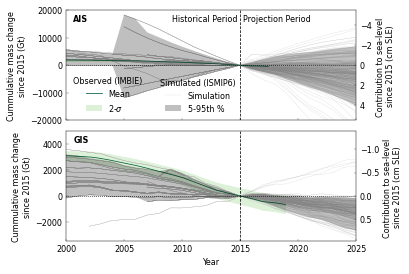

In [40]:
historical_filename = "IS_historical.pdf"
plot_historical(historical_filename, ismip6, imbie)

## Appendix figure: control run removed

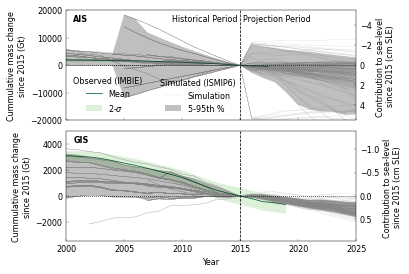

In [41]:
historical_filename = "IS_historical_ctrl_removed.pdf"
plot_historical(historical_filename, ismip6_ctrl_removed, imbie)

In [38]:
def plot_historical_partitioning(
    out_filename, ismip6, observed, x_lim=[2000, 2015], ice_sheet = "GIS"):
    
    def plot_signal(g, ax):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df[f"{p_var} (Gt/yr)"]
        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    fig, axs = plt.subplots(2, 1, sharex="col", figsize=[5.2, 4.25])
    fig.subplots_adjust(hspace=0.1, wspace=0.25)
    
    for k, p_var in enumerate(["Rate of surface mass balance anomaly", "Rate of ice dynamics anomaly"]):
        plot_var = f"{p_var} (Gt/yr)"
        df = ismip6[ismip6["IS"] == ice_sheet]
        imbie = observed[observed["IS"] == ice_sheet]

        [plot_signal(g, axs[k]) for g in df.groupby(by=["Group", "Model", "Exp"])]

        ismip6_mean = df.groupby(by="Year")[plot_var].mean().dropna()
        ismip6_low = df.groupby(by="Year")[plot_var].quantile(0.05).dropna()
        ismip6_high = df.groupby(by="Year")[plot_var].quantile(0.95).dropna()

        ismip6_ci = axs[k].fill_between(
            ismip6_mean.index,
            ismip6_low,
            ismip6_high,
            color="0.0",
            alpha=0.25,
            linewidth=0.0,
            zorder=10,
            label="5-95th %",
        )
        ismip6_line = axs[k].plot(
            ismip6_mean.index,
            ismip6_mean,
            "-",
            color="k",
            linewidth=imbie_signal_lw,
            zorder=25,
            label="Mean",
        )


        imbie_cis = []
        for s, sigma in enumerate([2]):
            imbie_ci = axs[k].fill_between(
                imbie["Year"],
                imbie[f"{p_var} (Gt/yr)"] - sigma * imbie[f"{p_var} uncertainty (Gt/yr)"],
                imbie[f"{p_var} (Gt/yr)"] + sigma * imbie[f"{p_var} uncertainty (Gt/yr)"],
                color=imbie_sigma_colors[s],
                alpha=0.5,
                linewidth=0,
                zorder=20,
                label=f"{sigma}-$\sigma$"
            )
            imbie_cis.append(imbie_ci)

        imbie_line = axs[k].plot(
            imbie["Year"],
            imbie[plot_var],
            "-",
            color=imbie_signal_color,
            linewidth=imbie_signal_lw,
            zorder=25,
            label="Mean",
        )
        axs[k].set_xlim(x_lim)
    axs[0].set_ylim(-250, 750)
    axs[1].set_ylim(-1000, 0)
    axs[0].set_ylabel("SMB (Gt/yr)")
    axs[1].set_ylabel("D (Gt/yr)")

    fig.savefig(out_filename, bbox_inches="tight", dpi=300)
 

## Plot flux partitioning for Greenland

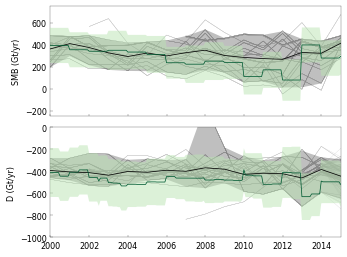

In [39]:
plot_historical_partitioning("GIS_historical_fluxes.png", ismip6, imbie)